<a href="https://colab.research.google.com/github/Rohandabas/personality-detection/blob/main/Personality_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving personality detection.zip to personality detection.zip
   type                                              posts
0  INFJ  'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1  ENTP  'I'm finding the lack of me in these posts ver...
2  INTP  'Good one  _____   https://www.youtube.com/wat...
3  INTJ  'Dear INTP,   I enjoyed our conversation the o...
4  ENTJ  'You're fired.|||That's another silly misconce...
                                               posts  type
0  'http://www.youtube.com/watch?v=qsXHcwe3krw|||...     0
1  'I'm finding the lack of me in these posts ver...     1
2  'Good one  _____   https://www.youtube.com/wat...     2
3  'Dear INTP,   I enjoyed our conversation the o...     3
4  'You're fired.|||That's another silly misconce...     4
K-Nearest Neighbors Accuracy: 0.315850144092219
K-Nearest Neighbors Classification Report:
               precision    recall  f1-score   support

           0       0.30      0.30      0.30       288
           1       0.23      

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Random Forest Accuracy: 0.39654178674351587
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.39      0.50      0.43       288
           1       0.77      0.13      0.22       135
           2       0.53      0.44      0.48       293
           3       0.52      0.34      0.41       193
           4       0.00      0.00      0.00        44
           5       0.00      0.00      0.00        41
           6       0.34      0.88      0.49       370
           7       0.56      0.04      0.07       125
           8       0.00      0.00      0.00        53
           9       1.00      0.01      0.03        67
          10       0.00      0.00      0.00        45
          11       0.00      0.00      0.00        44
          12       0.00      0.00      0.00        15
          13       0.00      0.00      0.00         8
          14       0.00      0.00      0.00         7
          15       0.00      0.00      0.00         7

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



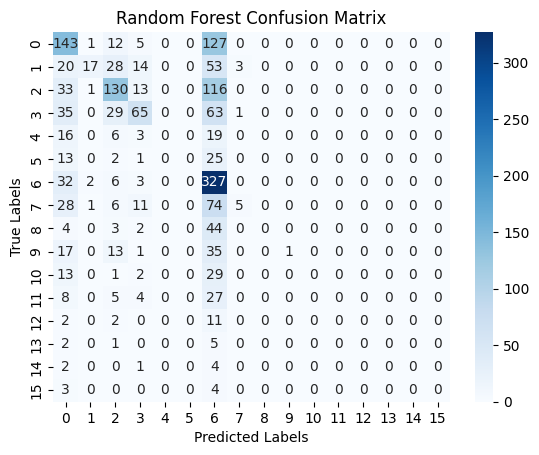

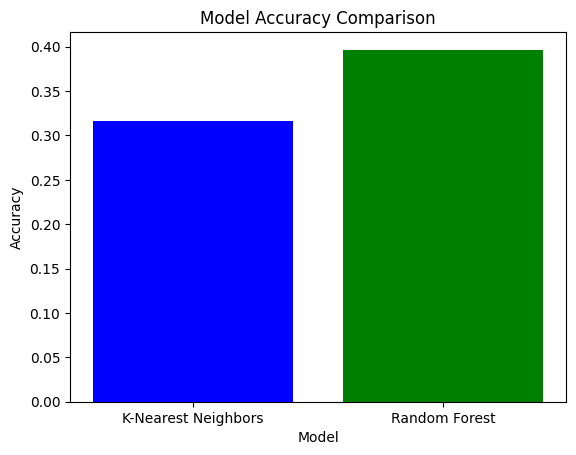

In [17]:
# Install additional libraries if not available
!pip install scikit-learn matplotlib seaborn

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Upload dataset
from google.colab import files
uploaded = files.upload()  # Upload the dataset file

# Load the dataset (use the correct file name after upload)
df = pd.read_csv("mbti_1.csv")  # Replace with the correct file name if necessary

# Inspect the dataset to verify the structure and column names
print(df.head())  # Print the first few rows to inspect the columns

# Clean the data (select relevant columns and drop missing values)
df = df[['posts', 'type']]  # Replace 'posts' with the actual text column name, if needed
df = df.dropna()  # Drop rows with missing values

# Encode personality types as numeric labels
df['type'] = pd.factorize(df['type'])[0]

# Display the first few rows of the cleaned data
print(df.head())

# Data Preprocessing (text vectorization)
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['posts'])  # Vectorize the posts column
y = df['type']  # The target column (personality type)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize classifiers
knn_classifier = KNeighborsClassifier(n_neighbors=5)
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the K-Nearest Neighbors classifier
knn_classifier.fit(X_train, y_train)

# Make predictions
knn_predictions = knn_classifier.predict(X_test)

# Evaluate the K-Nearest Neighbors model
print("K-Nearest Neighbors Accuracy:", accuracy_score(y_test, knn_predictions))
print("K-Nearest Neighbors Classification Report:\n", classification_report(y_test, knn_predictions))
print("K-Nearest Neighbors Confusion Matrix:\n", confusion_matrix(y_test, knn_predictions))

# Train the Random Forest classifier
rf_classifier.fit(X_train, y_train)

# Make predictions
rf_predictions = rf_classifier.predict(X_test)

# Evaluate the Random Forest model
print("Random Forest Accuracy:", accuracy_score(y_test, rf_predictions))
print("Random Forest Classification Report:\n", classification_report(y_test, rf_predictions))
print("Random Forest Confusion Matrix:\n", confusion_matrix(y_test, rf_predictions))

# Visualize the confusion matrix for Random Forest
sns.heatmap(confusion_matrix(y_test, rf_predictions), annot=True, fmt="d", cmap="Blues")
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Visualize the accuracy comparison between KNN and Random Forest
models = ['K-Nearest Neighbors', 'Random Forest']
accuracies = [accuracy_score(y_test, knn_predictions), accuracy_score(y_test, rf_predictions)]

plt.bar(models, accuracies, color=['blue', 'green'])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.show()


In [22]:
# List of all personality types in order (ensure this matches the encoding order)
personality_types_list = [
    'INTJ', 'INFJ', 'INTP', 'ISFJ', 'ISFP', 'INFP', 'ISTJ', 'ISTP',
    'ENFJ', 'ENFP', 'ENTJ', 'ENTP', 'ESFJ', 'ESFP', 'ESTJ', 'ESTP'
]

# Define the introvert and extrovert categories based on the list above
introverts = ['INTJ', 'INFJ', 'INTP', 'ISFJ', 'ISFP', 'INFP', 'ISTJ', 'ISTP']
extroverts = ['ENFJ', 'ENFP', 'ENTJ', 'ENTP', 'ESFJ', 'ESFP', 'ESTJ', 'ESTP']

# Function to map the numeric prediction to introvert or extrovert
def map_to_introvert_extrovert(predicted_personality):
    predicted_type = personality_types_list[predicted_personality]  # Map number to type
    if predicted_type in introverts:
        return "You are an Introvert"
    elif predicted_type in extroverts:
        return "You are an Extrovert"
    else:
        return "Unknown Personality Type"

# Example new posts (input your own texts here)
new_posts = [
    "I love reading books and spending time alone",
    "I enjoy talking to strangers and meeting new people"
]

# Preprocess the new posts (vectorization)
new_posts_vectorized = vectorizer.transform(new_posts)

# Make predictions using the trained model (e.g., Random Forest)
predictions = rf_classifier.predict(new_posts_vectorized)

# Decode the numeric predictions back to personality types and classify as Introvert or Extrovert
for post, prediction in zip(new_posts, predictions):
    personality_type = personality_types_list[prediction]
    personality_category = map_to_introvert_extrovert(prediction)

    print(f"Post: {post}\nPredicted Personality: {personality_type}\n{personality_category}\n")


Post: I love reading books and spending time alone
Predicted Personality: ISTJ
You are an Introvert

Post: I enjoy talking to strangers and meeting new people
Predicted Personality: ISTJ
You are an Introvert

